In [163]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
import os
import gzip
import numpy as np
from sklearn.linear_model import *
from sklearn.preprocessing import StandardScaler

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import joblib

from hw1 import *

In [3]:
# data_dir="/Users/michellehu/git_dirs/ComplexSystems_AMATH563/data/"
wd="/mnt/Backups/jmhu"

data_dir=wd+"/git_dirs/ComplexSystems_AMATH563/data/"
model_dir=wd+"/git_dirs/ComplexSystems_AMATH563/models/"
fig_dir = wd+"/git_dirs/ComplexSystems_AMATH563/figures/"
    
if not os.path.exists(data_dir):
    !mkdir $data_dir

if not os.path.exists(model_dir):
    !mkdir $model_dir

if not os.path.exists(fig_dir):
    !mkdir $fig_dir

## Load data

In [4]:
with open(data_dir+"pickled_mnist.pkl", 'rb') as f:
    trainX, testX, trainY, testY = pickle.load(f)

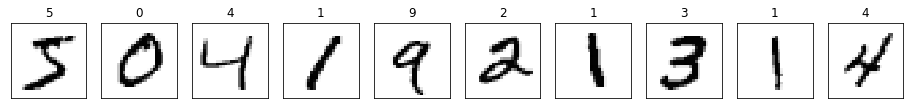

In [5]:
# Check out some digits
plt.figure(figsize=(16,4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = trainX[i].reshape((28,28))
    ax.imshow(img, cmap="Greys")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(trainY[i])

---

## Reassign matrix names

In [6]:
# A is the vectorized MNIST training images
A=trainX.copy()
print(A.shape)

# B is the set of output vectors
B=trainY.copy()
print(B.shape)

(60000, 784)
(60000,)


## Normalize data

In [7]:
print(A.min(), A.max())

scaler = StandardScaler()

A = scaler.fit_transform(A)
testX = scaler.transform(testX)

B = np.array(B)
testY = np.array(testY)

print(A.min(), A.max())

0 255
-1.2742078920822268 244.94693302873063


### Question 1.
Using various AX=B solvers, determine a mapping from the image space (A) to the label space (B)

**Approach:** pick two solvers and vary regularization (guided by exploration runs)

In [8]:
solver_names = [
           "saga_elastic_L1_C01_mult", 
           "saga_elastic_L2_C01_mult",
           "saga_elastic_mix_C01_mult",
           "saga_elastic_half_C01_mult",
           "sgd_elastic_L2_C0005_mult"
          ]

In [10]:
%%time
n_jobs=4
tol=0.01

solvers=[]
l1_ratio = [1, 0, 0.8, 0.5]
multi_class="multinomial"

# saga + varying penalties
# with stochastic average gradient descent and L2 regularization

for i, model in enumerate(solver_names):
    if i+1 < (len(solver_names)):
        model=LogisticRegression(solver="saga", 
                                 multi_class=multi_class, 
                                 C=0.1, 
                                 penalty="elasticnet", 
                                 l1_ratio=l1_ratio[i],
                                 n_jobs=n_jobs, 
                                 tol=tol)
    else:
        model=LogisticRegression(solver="sag", 
                                 multi_class=multi_class, 
                                 C=0.005, 
                                 penalty="l2", 
                                 n_jobs=n_jobs, 
                                 tol=tol)

    solvers.append(model)

CPU times: user 21 µs, sys: 10 µs, total: 31 µs
Wall time: 34.6 µs


In [11]:
solvers

[LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=1, max_iter=100,
                    multi_class='multinomial', n_jobs=4, penalty='elasticnet',
                    random_state=None, solver='saga', tol=0.01, verbose=0,
                    warm_start=False),
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=0, max_iter=100,
                    multi_class='multinomial', n_jobs=4, penalty='elasticnet',
                    random_state=None, solver='saga', tol=0.01, verbose=0,
                    warm_start=False),
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=0.8, max_iter=100,
                    multi_class='multinomial', n_jobs=4, penalty='elasticnet',
                    random_state=None, solver='saga', tol=0.01, verbose=0,
                    war

## Test times without cross-validation

0
193.20 sec elapsed
saga_elastic_L1_C01_mult trained
Saving as hw1_cmsaga_elastic_L1_C01_mult.png
1
68.44 sec elapsed
saga_elastic_L2_C01_mult trained
Saving as hw1_cmsaga_elastic_L2_C01_mult.png
2
187.28 sec elapsed
saga_elastic_mix_C01_mult trained
Saving as hw1_cmsaga_elastic_mix_C01_mult.png
3
181.67 sec elapsed
saga_elastic_half_C01_mult trained
Saving as hw1_cmsaga_elastic_half_C01_mult.png
4
64.63 sec elapsed
sgd_elastic_L2_C0005_mult trained
Saving as hw1_cmsgd_elastic_L2_C0005_mult.png


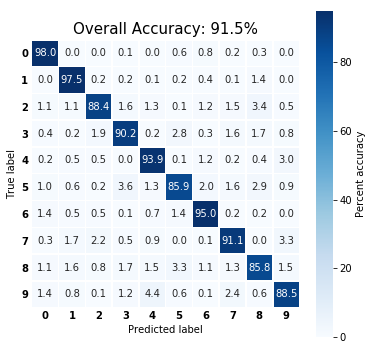

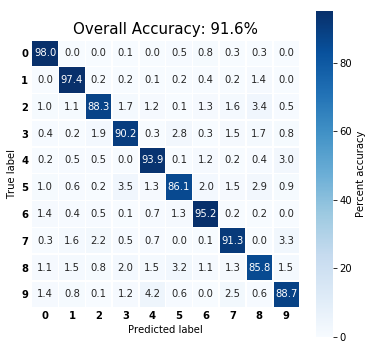

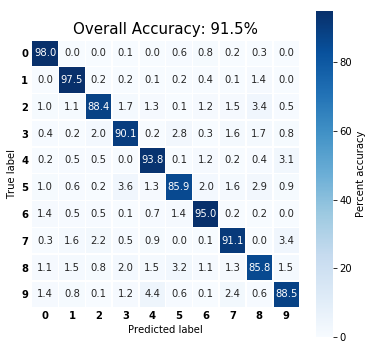

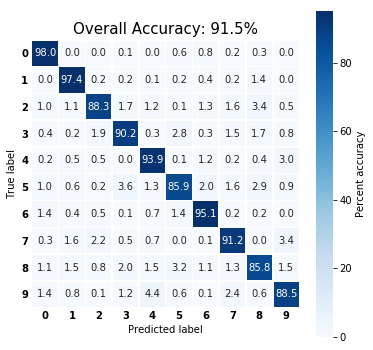

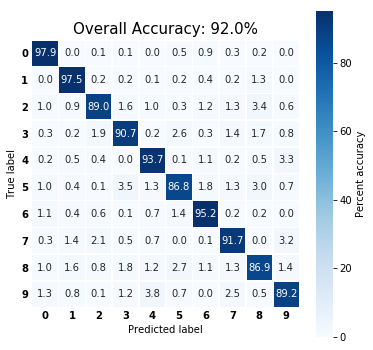

In [14]:
import time

models = []

# arrays will be arranged with different solutions in columns
preds = np.zeros((len(testX), len(solver_names)))
accs = np.zeros((len(solver_names)))
reports = []
matrices = np.zeros((10, 10*len(solver_names)))

# Optimize, calculate losses and save confusion matrix
for i, (model, model_name) in enumerate(zip(solvers, solver_names)):
    print(i)
    model_fn=model_dir + model_name + ".pkl"
    
    if os.path.exists(model_fn):
        trained_model = joblib.load(model_fn)
        pred = trained_model.predict(testX)
        acc = trained_model.score(testX, testY)
        
        print("Model exists and loaded")
        
    else:
        start=time.time()
        trained_model, pred, acc = optimize(model, A, B, testX, testY)  
        print("{0:.2f}".format(time.time()-start), "sec elapsed")

        print(model_name, "trained")
        
        joblib.dump(model, model_fn)

    models.append(trained_model)
    preds[:, i] = pred
    accs[i] = acc
    
    r, m = compute_loss(trained_model, pred, testX, testY)
    matrices[:, 10*i : 10*i + 10] = m
    reports.append(r)

    fig_name = fig_dir+"hw1_cm" + model_name + ".png"

    plot_confusion(m, acc, save_fn = fig_name)

### Question 2

Promote sparsity and rank which pixels are most informative for digit labelling

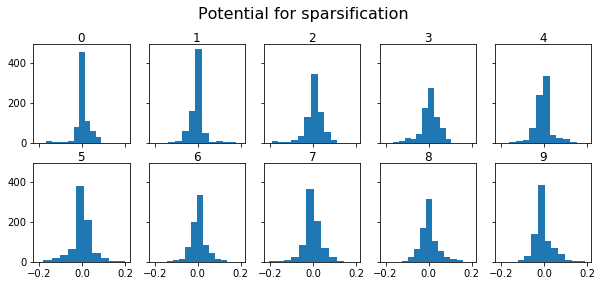

In [168]:
hist_coef(trained_model)

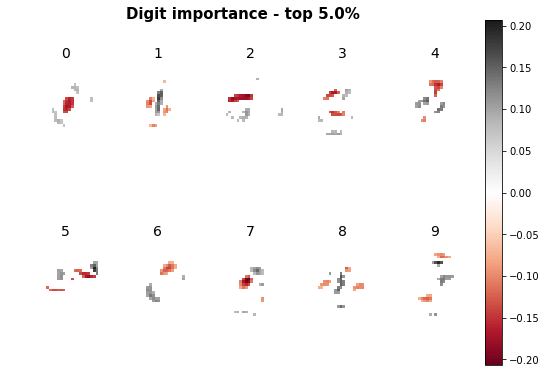

In [159]:
plot_vip(trained_model)

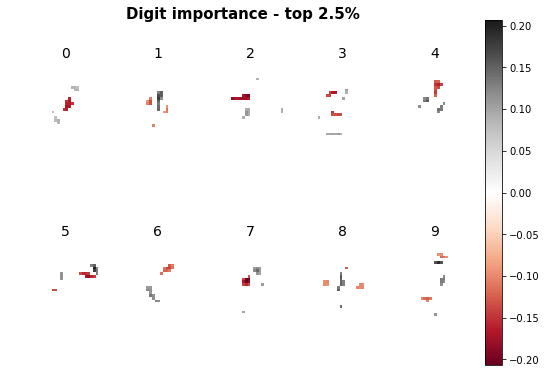

In [187]:
trained_model = joblib.load(model_fn)
plot_vip(trained_model, p=1.25)

Use L1  
rank the 784 pixels to see which is most informative  
Most informative = largest coefficients in matrix X (trained_model.coef_) --> top 5% of pixels, visualized

Locate these pixel indices

In [189]:
coef=trained_model.coef_

In [518]:
from sklearn.utils.extmath import density
density(coef)

0.9145408163265306

# look at the number 5, coefficients are provided for each number in order

In [412]:
i=0
p=1.25

cmin, cmax = (np.percentile(coef[i],p), np.percentile(coef[i],100-p))
inds=np.indices(coef[i].shape).squeeze()
inds[(coef[i] > cmin) & (coef[i] < cmax)] = 9999
inds=inds[inds!=9999]
inds
# important_coef=coef[i][inds]
# important_coef

array([240, 241, 242, 269, 270, 351, 378, 379, 406, 407, 408, 434, 435,
       461, 462, 485, 542, 570, 571, 599])

In [522]:
new_trainX_digit.shape

(5949, 784)

0


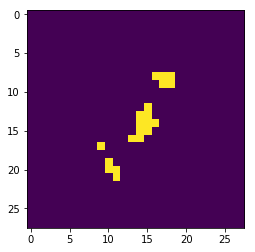

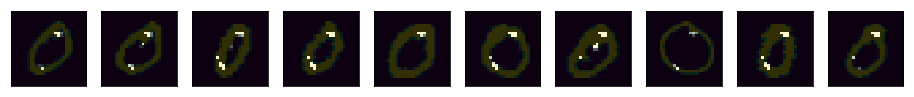

1


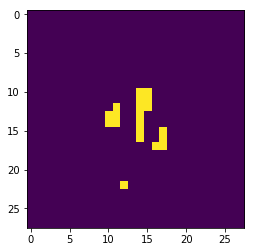

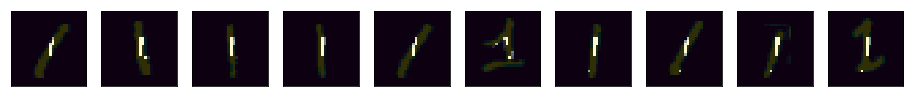

2


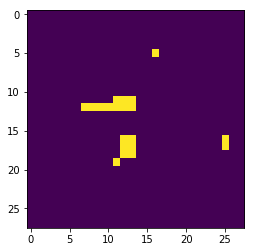

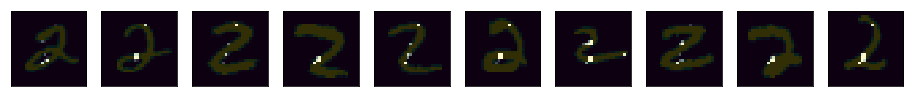

3


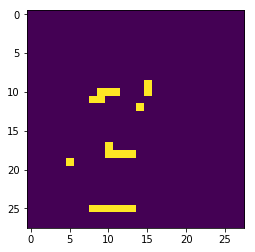

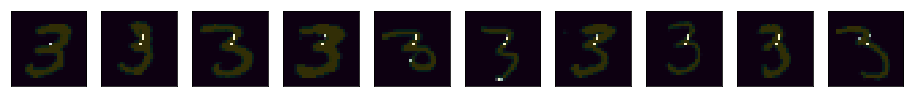

4


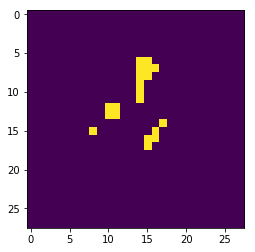

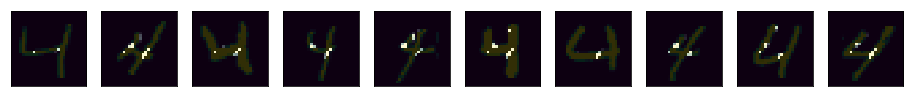

5


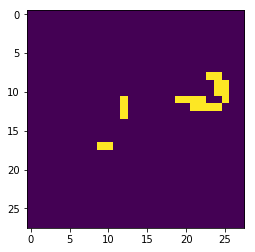

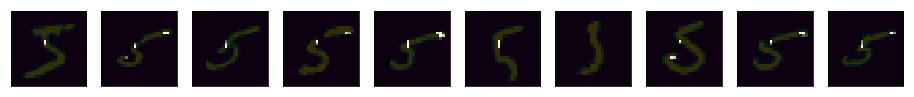

6


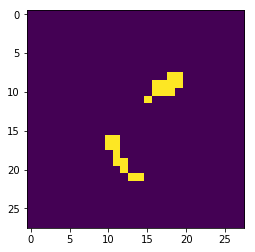

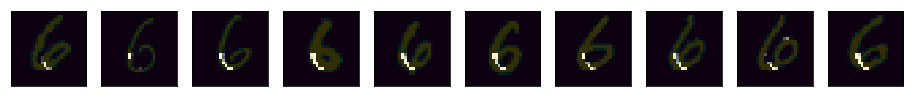

7


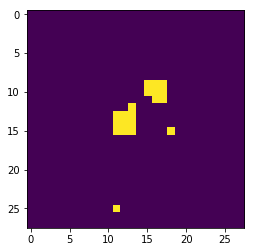

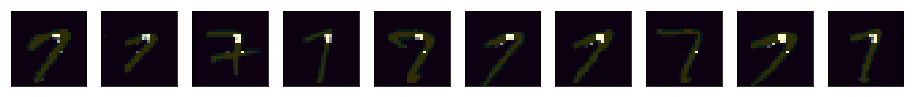

8


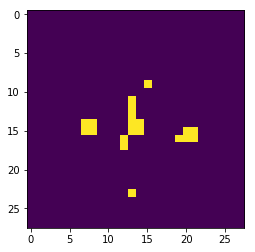

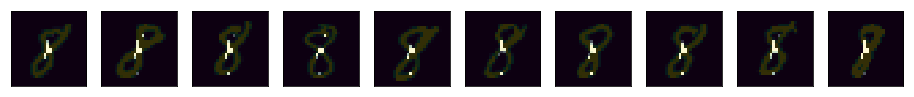

9


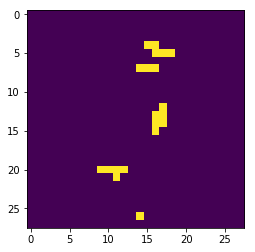

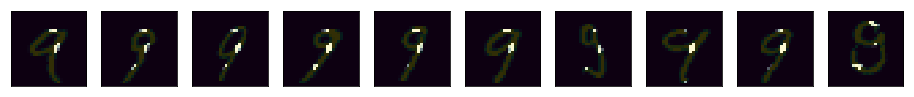

In [540]:
p=1.25
indices=[]

testX_digits=testX.copy()
trainX_digits=trainX.copy()

new_trainX_digits=np.empty_like(trainX_digits)

def fandr(in_img, indices):
    '''
    Return input image with only values at specified indices
    '''
    new_img=np.zeros_like(in_img)
    new_img[indices] = in_img[indices]
    return(new_img)

for digit in range(10):
    print(digit)
    cmin, cmax = (np.percentile(coef[digit],p), np.percentile(coef[digit],100-p))
    inds=np.indices(coef[digit].shape).squeeze()

    # Extract indices from thresholded model coefficients
    inds[(coef[digit] > cmin) & (coef[digit] < cmax)] = 9999
    inds=inds[inds!=9999]
    
    # temp storage for double checks
    indices.append(inds)
    
    # blank image
    test_img=np.zeros_like(coef[digit])
    test_img[inds] = 255

    # important pixels for this digit
    plt.figure()
    plt.imshow(test_img.reshape(28,28))    
    
    # Use indices to extract new training and test X dataset
    # For only the training images that are labeled 0
    trainX_digit=trainX_digits[trainY==digit,:]
    new_trainX_digit=np.apply_along_axis(fandr, indices=inds, axis=1, arr=trainX_digit)
    new_trainX_digits[trainY==digit,:]=new_trainX_digit

    # Check out some digits
    plt.figure(figsize=(16,4))

    for j in range(10):
        ax = plt.subplot(1, 10, j + 1)
        img = trainX_digit[j].reshape((28,28))
        img2 = new_trainX_digit[j].reshape((28,28))
        ax.imshow(img)
        ax.imshow(img2, cmap=plt.cm.Greys_r, alpha=0.8)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

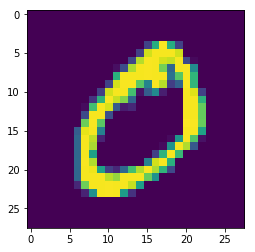

In [413]:
q=1
test_five = trainX_digits[q].copy()
plt.imshow(test_five.reshape(28,28))

In [446]:
two_images=trainX_digits[:2].copy()
test_images=np.zeros_like(two_images)
test_images.shape

(2, 784)

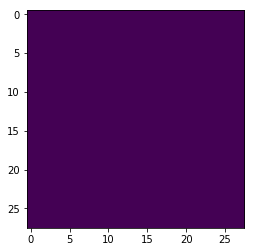

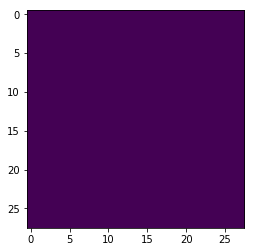

In [448]:
plt.figure()
plt.imshow(test_images[0].reshape(28,28))
plt.figure()
plt.imshow(test_images[1].reshape(28,28))

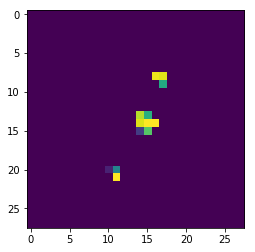

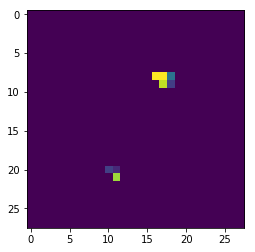

In [476]:
test_images[0][inds]=two_images[0][inds]
test_images[1][inds]=two_images[1][inds]

plt.figure()
plt.imshow(test_images[0].reshape(28,28))
plt.figure()
plt.imshow(test_images[1].reshape(28,28))

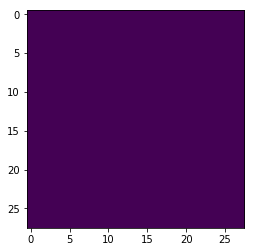

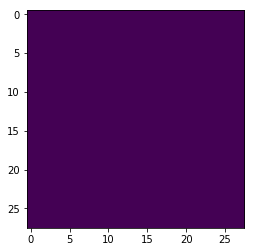

In [483]:
test_images=np.zeros_like(two_images)
plt.figure()
plt.imshow(test_images[0].reshape(28,28))
plt.figure()
plt.imshow(test_images[1].reshape(28,28))

In [496]:
def fandr(in_img, indices):
    new_img=np.zeros_like(in_img)
    new_img[indices] = in_img[indices]
    return(new_img)

z=np.apply_along_axis(fandr, indices=inds, axis=1, arr=two_images)

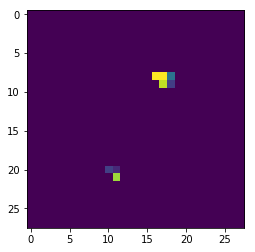

In [500]:
z=fandr(two_images[1], inds)
plt.imshow(z.reshape(28,28))

In [508]:
z=np.apply_along_axis(fandr, indices=inds, axis=1, arr=two_images)
z.shape

(2, 784)

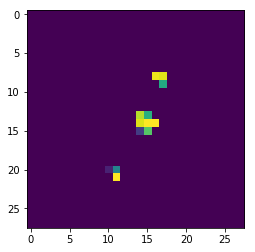

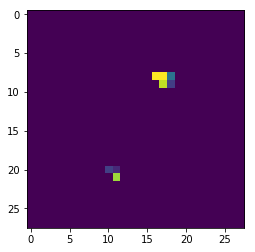

In [509]:
# Try to do this at once
f=np.take(two_images, indices=inds, axis=1)
np.put(test_images, inds, f)
plt.figure()
plt.imshow(z[0].reshape(28,28))
plt.figure()
plt.imshow(z[1].reshape(28,28))

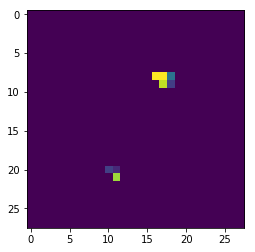

In [437]:
# extract proper pixels for training
test_vip=np.zeros_like(trainX_digits[q])
test_vip[inds]=trainX_digits[q][inds]
# test_vip[inds]=255
plt.imshow(test_vip.reshape(28,28))

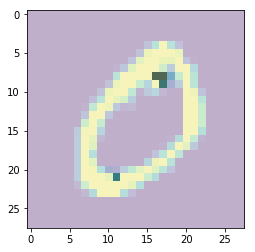

In [415]:
plt.figure()
plt.imshow(trainX_digits[q].reshape(28,28))
plt.imshow(test_vip.reshape(28,28), cmap=plt.cm.Blues, alpha=0.7)

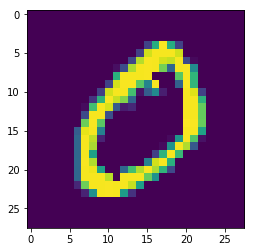

In [436]:
np.put_along_axis(test_five, inds, 0, axis=0)
plt.imshow(test_five.reshape(28,28))

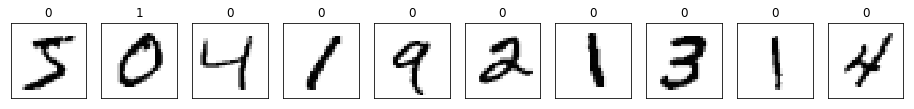

In [403]:
# Check out some digits
plt.figure(figsize=(16,4))

for j in range(10):
    ax = plt.subplot(1, 10, j + 1)
    img = trainX_digits[j].reshape((28,28))
    ax.imshow(img, cmap="Greys")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(trainY_digits[i][j])

In [ ]:
# Use the indices to extract training data and reduce sizes
trainX_zero
trainY_zero

### Question 3
Apply your most important pixels to the test data set to see how accurate you are with as few pixels as possible.

In [184]:
# sparse_coef
sparse_model=trained_model.sparsify()

### Question 4
Redo the analysis with each digit individually to find the most important pixels for each digit.

In [44]:
print(testY_digit.shape)
print(trainY_digit.shape)


(10000,)
(60000,)


In [50]:
# Relabel test and training data for each digit (previously normalized above)
testY_digits=np.zeros((10, len(testY)), dtype='uint8')
trainY_digits=np.zeros((10, len(trainY)), dtype='uint8')

testX_digits=testX.copy()
trainX_digits=trainX.copy()

for digit in range(10):
    print(digit)
    testY_digit=testY.copy()
    testY_digit[testY != float(digit)] = 0
    testY_digit[testY == float(digit)] = 1

    trainY_digit=trainY.copy()
    trainY_digit[trainY !=float(digit)] = 0
    trainY_digit[trainY == float(digit)] = 1    
    
    # Put into the array
    testY_digits[digit,:]=testY_digit
    trainY_digits[digit,:]=trainY_digit

0
1
2
3
4
5
6
7
8
9


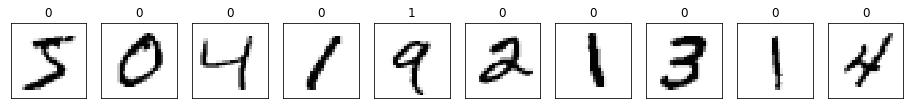

In [51]:
# Check out some digits
plt.figure(figsize=(16,4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = trainX_digits[i].reshape((28,28))
    ax.imshow(img, cmap="Greys")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(trainY_digits[9][i])

In [52]:
# Specify model and regularization to use
i=2
saga_digit=solvers[i]
print(solver_names[i])

saga_elastic_mix_C01_mult


In [ ]:
%%time

for i in range(10):
    A=trainX_digits
    B=trainY_digits[i]
    testX=testX_digits
    testY=testY_digits[i]
    
    model=saga_digit

    model_name = "digit_" + i + "_saga_elastic_mix_C01_mult"
    model_fn = model_dir + model_name + ".pkl"
    
    trained_model, pred, acc = optimize(model, A, B, testX, testY)  
    print(model_name, "trained")

    joblib.dump(model, model_fn)

    r, m = compute_loss(trained_model, pred, testX, testY)

    fig_name=fig_dir+model_name+"hw1_conf_matrix.png"
    # print(fig_name)
    plot_confusion(m, save_fn=fig_name)

    plt.figure()

    plt.imshow(trained_model.coef_.reshape(28,28))

In [ ]:
lim=max(np.abs(trained_model.coef_.min()), np.abs(trained_model.coef_.max()))

plt.imshow(trained_model.coef_.reshape(28,28), vmin=-lim, vmax=lim, cmap=plt.cm.RdGy)
plt.colorbar()

### Question 5
Think about the interpretation of what you are doing with this AX = B problem.


In [ ]:
f(x) = something
A = trainX (observations)
B = trainY (labels)

X = beta = loadings so we can transform (i.e. map) A (e.g. data, observations, images) into B (e.g. labels)
The way I've been doing this above has been using 10 different X's -- or a one vs. all approach 
see this https://towardsdatascience.com/kannada-visual-model-952cc6ec3a72 and this https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

Determine X using logistic regression specifying solvers, an error function, and regularization (constraints, penalties to tweak the function)
Use L1 norm where we minimize the average error (better performance with outliers than L2 norm)

Ranking most informative pixels

In [ ]:
# Convert labels to float type
train_labels = np.asfarray(trainY)
test_labels = np.asfarray(testY)


lr = np.arange(len(np.unique(test_labels)))

# transform labels into one hot representation
train_labels_one_hot = (lr==train_labels.reshape(60000,1)).astype(np.float)
test_labels_one_hot = (lr==test_labels.reshape(10000,1)).astype(np.float)

# we don't want zeroes and ones in the labels:
train_labels_one_hot[train_labels_one_hot==0] = 0.01
train_labels_one_hot[train_labels_one_hot==1] = 0.99
test_labels_one_hot[test_labels_one_hot==0] = 0.01
test_labels_one_hot[test_labels_one_hot==1] = 0.99